### Introduction
Restaurant business is considered to be stable if the demographics requirements are met. Especially, crowded metropolis areas require restaurants for busy people who work in the city and prefer dining-out than cooking at home. For our studies we are interested in Japanese cuisine as it is the favorite of big audiences, starting from vegans to people of any age.
Location-wise Toronto is the most-populated city in Canada with over 6 million people in 2020 with the highest median salary of 123,000 CAD across the country. Thus it is believed that restaurant business goes well around the city. This study is going to analyze the best possible location for our Japanese Restaurant in Toronto, Canada so potential stakeholders could have great success and consistent profit.

### Business Problem
The objective of this project is to analyze and select the best locations in the city of Toronto, Canada to open a new Japanese restaurant. Utilizing data science methodology and instruments such as data analysis and data visualization project aims to provide solutions for our business problem: Where in Toronto, Canada should the investor open a Japanese Restaurant.

### Data Description
To proceed with studies we will be using the following data:
    • Toronto, Canada data containing neighborhoods and boroughs
    • Latitude and Longitude coordinates of these neighborhoods for plotting the map
    • Venue data, namely restaurants data of Toronto



### Data Source
Toronto data source for neighborhoods and boroughs will be obtained from Wikipedia and wrangled with python pandas library. Further, we will retrieve geographical coordinates (latitude, longitude) from the website: http://cocl.us/Geospatial_data provided by IBM.
Additionally, we are going to use Foursquare API to get venue data for the neighborhoods. Foursquare is one of the largest database for location data with over 100 million places. Foursquare API provides different categories of the venue data, particularly we are interested in restaurant data to find the solution to our business problem.

### 1. Libraries are downloaded to proceed to work with data

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


### 1.1 Foursquare Credentials

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'Q0FXNM3K4CCA5UXQHP5ZEK2WB2OLZ0ZDLJGIRFJBCB2YJT1M' # your Foursquare ID
CLIENT_SECRET = 'RO2434WPVRRKGNKBP121SMC2YA53G32DVRYLRYBSKXCEYC41' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


### 1.2 Download Data for Toronto, Canada

In [3]:
# First, we download html of Toronto boroughs into our notebook

pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

# Secondly, we define our dataframe and assign it to pandas dataframe to have a clean look

toronto_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Thirdly, we drop Boroughs with Not assigned values
# And assign Borough names to Neighbourhoods with 'Not assigned' values

t_df = toronto_df[toronto_df.Borough != 'Not assigned'].reset_index().drop('index', axis=1)
for index, row in t_df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']
        
# Here, we download csv of postal codes lattitude and longitude

latlong_df = pd.read_csv('http://cocl.us/Geospatial_data')

# Joining 2 Dataframes, namely Boroughs, Neighbourhoods with Lattitude, Longitude into 1

tor_df = t_df.set_index('Postal Code').sort_values(by='Postal Code')
ll_df = latlong_df.set_index('Postal Code').sort_values(by='Postal Code')
df_join = pd.concat([tor_df, ll_df], axis=1)
toronto_df = df_join.reset_index()
toronto_data = toronto_df.drop(['Postal Code'], axis=1)
toronto_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


### 1.3 Define Functions for further use in our Project

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### 2. Data Analysis to find out number of Japanese Restaurants in Toronto

In [5]:
# Prepare neighborhood list that contains japanese restaurants

column_names=['Borough', 'Neighbourhood', 'ID','Name']
japanese_rest_t=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(toronto_data),')','Japanese Restaurants in '+Neighbourhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_t = japanese_rest_t.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Japanese Restaurants in Malvern, Rouge, Scarborough:0
['Scarborough', 'Malvern, Rouge', 43.806686299999996, -79.19435340000001]
( 2 / 103 ) Japanese Restaurants in Rouge Hill, Port Union, Highland Creek, Scarborough:0
['Scarborough', 'Rouge Hill, Port Union, Highland Creek', 43.7845351, -79.16049709999999]
( 3 / 103 ) Japanese Restaurants in Guildwood, Morningside, West Hill, Scarborough:0
['Scarborough', 'Guildwood, Morningside, West Hill', 43.7635726, -79.1887115]
( 4 / 103 ) Japanese Restaurants in Woburn, Scarborough:0
['Scarborough', 'Woburn', 43.7709921, -79.21691740000001]
( 5 / 103 ) Japanese Restaurants in Cedarbrae, Scarborough:0
['Scarborough', 'Cedarbrae', 43.773136, -79.23947609999999]
( 6 / 103 ) Japanese Restaurants in Scarborough Village, Scarborough:0
['Scarborough', 'Scarborough Village', 43.7447342, -79.23947609999999]
( 7 / 103 ) Japanese Restaurants in Kennedy Park, Ionview, East Birchmount Park, Scarborough:0
['Scarborough', 'Kennedy Park, Ionview, Eas

( 56 / 103 ) Japanese Restaurants in St. James Town, Downtown Toronto:2
['Downtown Toronto', 'St. James Town', 43.6514939, -79.3754179]
( 57 / 103 ) Japanese Restaurants in Berczy Park, Downtown Toronto:0
['Downtown Toronto', 'Berczy Park', 43.644770799999996, -79.3733064]
( 58 / 103 ) Japanese Restaurants in Central Bay Street, Downtown Toronto:3
['Downtown Toronto', 'Central Bay Street', 43.6579524, -79.3873826]
( 59 / 103 ) Japanese Restaurants in Richmond, Adelaide, King, Downtown Toronto:3
['Downtown Toronto', 'Richmond, Adelaide, King', 43.65057120000001, -79.3845675]
( 60 / 103 ) Japanese Restaurants in Harbourfront East, Union Station, Toronto Islands, Downtown Toronto:1
['Downtown Toronto', 'Harbourfront East, Union Station, Toronto Islands', 43.6408157, -79.38175229999999]
( 61 / 103 ) Japanese Restaurants in Toronto Dominion Centre, Design Exchange, Downtown Toronto:2
['Downtown Toronto', 'Toronto Dominion Centre, Design Exchange', 43.6471768, -79.38157640000001]
( 62 / 103 

( 102 / 103 ) Japanese Restaurants in South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens, Etobicoke:0
['Etobicoke', 'South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens', 43.739416399999996, -79.5884369]
( 103 / 103 ) Japanese Restaurants in Northwest, West Humber - Clairville, Etobicoke:0
['Etobicoke', 'Northwest, West Humber - Clairville', 43.706748299999994, -79.5940544]


In [10]:
#japanese_rest_t.to_csv('japanese_rest_t_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_t.to_csv('japanese_rest_t_tocsv1.csv')

In [11]:
japanese_t = pd.read_csv('japanese_rest_t_tocsv1.csv')
japanese_rest_t.tail()

,Borough,Neighbourhood,ID,Name
28,Downtown Toronto,"First Canadian Place, Underground city",5a4fdf56772fbc5e9fa73c7f,Chotto Matte
29,Downtown Toronto,"First Canadian Place, Underground city",506a3830e4b0677a1f9d8eda,Ninki Izakaya
30,Downtown Toronto,"First Canadian Place, Underground city",4afa1f33f964a520e91622e3,Fune Japanese Restaurant
31,North York,Glencairn,4fca732be4b07c8e3e198c27,Miyako Sushi Restaurant
32,West Toronto,"Little Portugal, Trinity",51049684e4b06b57cac4e3e8,Bazara


In [12]:
japanese_rest_t.shape

(33, 4)

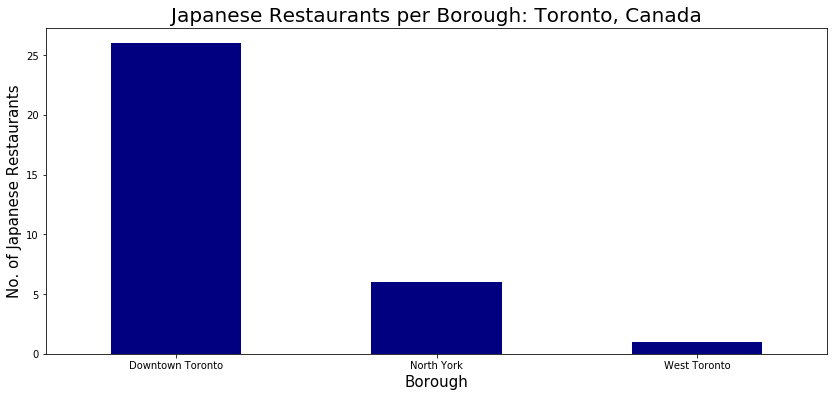

In [13]:
japanese_rest_t.groupby('Borough')['ID'].count().plot.bar(figsize=(14,6), color='navy')
plt.title('Japanese Restaurants per Borough: Toronto, Canada', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

As we can see from empirical results above, Toronto has the total of 33 Japanese Restaurants, majority of them, specifically 26 located in Downtown Toronto area.

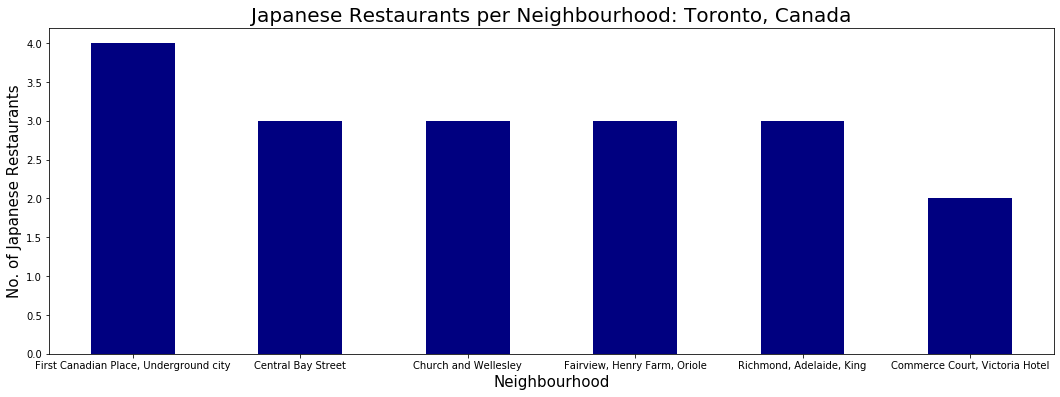

In [14]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_t.groupby('Neighbourhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(18,6), color='navy')
plt.title('Japanese Restaurants per Neighbourhood: Toronto, Canada', fontsize = 20)
plt.xlabel('Neighbourhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

###  2.1 Rankings of the Found Restaurants

In [15]:
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_t=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_t.values.tolist():
    Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_t),')','processed')
    japanese_rest_stats_t = japanese_rest_stats_t.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_t.tail()

{'meta': {'code': 200, 'requestId': '5f94fbe11c176430f1626a85'}, 'response': {'venue': {'id': '5952e5ed491be7022cf5d19f', 'name': 'Heart Sushi', 'contact': {}, 'location': {'address': '1800 Sheppard Avenue E', 'lat': 43.777203, 'lng': -79.343805, 'labeledLatLngs': [{'label': 'display', 'lat': 43.777203, 'lng': -79.343805}], 'postalCode': 'M2J', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1800 Sheppard Avenue E', 'Toronto ON M2J', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/heart-sushi/5952e5ed491be7022cf5d19f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 'Sushi Restaurants', 'shortName': 'Sushi', 'icon': {'prefix': 'https://ss3.4sqi.net/img/catego

{'meta': {'code': 200, 'requestId': '5f94fbe1b530f2033290d0bd'}, 'response': {'venue': {'id': '4be1b4df8c2bc9b6e4c0420b', 'name': 'Teriyaki Experience', 'contact': {'phone': '4169986297', 'formattedPhone': '(416) 998-6297'}, 'location': {'address': '1800 Sheppard Ave. E', 'lat': 43.77832992258357, 'lng': -79.34310953832035, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77832992258357, 'lng': -79.34310953832035}], 'postalCode': 'M2J 5A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1800 Sheppard Ave. E', 'Toronto ON M2J 5A7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/teriyaki-experience/4be1b4df8c2bc9b6e4c0420b', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 1}, 'url': 'https://w

{'meta': {'code': 200, 'requestId': '5f94fbe20bf98854154aee5b'}, 'response': {'venue': {'id': '5077025ce4b05aefca37d9f9', 'name': 'Wako Sushi + Bar', 'contact': {'phone': '4165514476', 'formattedPhone': '(416) 551-4476'}, 'location': {'address': '5213 Yonge Street', 'lat': 43.77080606720809, 'lng': -79.41313811956255, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77080606720809, 'lng': -79.41313811956255}], 'cc': 'CA', 'city': 'North York', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['5213 Yonge Street', 'North York ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/wako-sushi--bar/5077025ce4b05aefca37d9f9', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11c941735', 'name': 'Sake Bar', 'pluralName': 'Sake Bars', 'shortName': 'Sake B

{'meta': {'code': 200, 'requestId': '5f94fbe28d464035d6bc71e2'}, 'response': {'venue': {'id': '50cc21c37ab4d9c0594b6994', 'name': 'Kingyo Toronto', 'contact': {'phone': '6477482121', 'formattedPhone': '(647) 748-2121', 'twitter': 'kingyotoronto', 'facebook': '762851630440748', 'facebookUsername': 'Kingyotoronto', 'facebookName': 'Kingyo Izakaya Toronto'}, 'location': {'address': '51B Winchester St.', 'crossStreet': 'at Broadcast Ln.', 'lat': 43.66589495808371, 'lng': -79.36841520638596, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66589495808371, 'lng': -79.36841520638596}], 'postalCode': 'M4X 1R7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['51B Winchester St. (at Broadcast Ln.)', 'Toronto ON M4X 1R7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kingyo-toronto/50cc21c37ab4d9c0594b6994', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese

{'meta': {'code': 200, 'requestId': '5f94fbe2d16d0709a75677b5'}, 'response': {'venue': {'id': '4c193c77838020a1e768e561', 'name': 'Kawa Sushi', 'contact': {'phone': '4169212888', 'formattedPhone': '(416) 921-2888'}, 'location': {'address': '451 Church St.', 'lat': 43.66389438938988, 'lng': -79.38021009464505, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66389438938988, 'lng': -79.38021009464505}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['451 Church St.', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kawa-sushi/4c193c77838020a1e768e561', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'url': 'http://kawasushi.ca', 'price': {'tier': 2, 'message': 'Moderate', 'cur

{'meta': {'code': 200, 'requestId': '5f94fbe3bd28c54ba2a69170'}, 'response': {'venue': {'id': '4ae787b9f964a52020ac21e3', 'name': 'Tokyo Kitchen', 'contact': {'phone': '4165150387', 'formattedPhone': '(416) 515-0387'}, 'location': {'address': 'Charles St.', 'crossStreet': 'at Yonge St.', 'lat': 43.66878262373862, 'lng': -79.38515305215851, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66878262373862, 'lng': -79.38515305215851}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Charles St. (at Yonge St.)', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/tokyo-kitchen/4ae787b9f964a52020ac21e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'price': {'tier': 2, 'message': 

{'meta': {'code': 200, 'requestId': '5f94fbe32be1a37c28f8f49a'}, 'response': {'venue': {'id': '4c531b60a724e21e029e3af4', 'name': 'Kokoni Izakaya', 'contact': {'phone': '6473460886', 'formattedPhone': '(647) 346-0886'}, 'location': {'address': '459 Church St', 'crossStreet': 'Alexander St', 'lat': 43.664181433817156, 'lng': -79.38025833040214, 'labeledLatLngs': [{'label': 'display', 'lat': 43.664181433817156, 'lng': -79.38025833040214}], 'postalCode': 'M4Y 2C5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['459 Church St (Alexander St)', 'Toronto ON M4Y 2C5', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kokoni-izakaya/4c531b60a724e21e029e3af4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCoun

{'meta': {'code': 200, 'requestId': '5f94fbe461fa2753f84eecfd'}, 'response': {'venue': {'id': '4b2bd898f964a52042bc24e3', 'name': 'Kinka Izakaya Original', 'contact': {'phone': '4169770999', 'formattedPhone': '(416) 977-0999', 'twitter': 'kinkaizakayato', 'facebook': '160204064034815', 'facebookUsername': 'KinkaIzakayaToronto', 'facebookName': 'KINKA IZAKAYA TORONTO'}, 'location': {'address': '398 Church St', 'crossStreet': 'McGill Street', 'lat': 43.66059636632361, 'lng': -79.37889120754515, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66059636632361, 'lng': -79.37889120754515}], 'postalCode': 'M5B 2A2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['398 Church St (McGill Street)', 'Toronto ON M5B 2A2', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kinka-izakaya-original/4b2bd898f964a52042bc24e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Ja

{'meta': {'code': 200, 'requestId': '5f94fbe4589bc022c59cfc4b'}, 'response': {'venue': {'id': '599cb69eb5461876d54ab713', 'name': 'Katsuya', 'contact': {}, 'location': {'address': '66 Gerrard St E', 'lat': 43.65986035759321, 'lng': -79.37878806223506, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65986035759321, 'lng': -79.37878806223506}], 'postalCode': 'M5B 1G3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['66 Gerrard St E', 'Toronto ON M5B 1G3', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/katsuya/599cb69eb5461876d54ab713', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 14, 'groups': [{'type': 'o

{'meta': {'code': 200, 'requestId': '5f94fbe49d7cfa6c1bbad336'}, 'response': {'venue': {'id': '574ad72238fa943556d93b8e', 'name': 'Gyu-Kaku Japanese BBQ', 'contact': {'phone': '6473512378', 'formattedPhone': '(647) 351-2378', 'twitter': 'gyukakujbbq', 'instagram': 'gyukakujbbq', 'facebook': '201713573236475', 'facebookUsername': 'GyuKakuJBBQ', 'facebookName': 'Gyu-Kaku Japanese BBQ'}, 'location': {'address': '81 Church St', 'crossStreet': 'at Adelaide St E', 'lat': 43.651422275497914, 'lng': -79.37504693687086, 'labeledLatLngs': [{'label': 'display', 'lat': 43.651422275497914, 'lng': -79.37504693687086}], 'postalCode': 'M5C 2G2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['81 Church St (at Adelaide St E)', 'Toronto ON M5C 2G2', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/gyukaku-japanese-bbq/574ad72238fa943556d93b8e', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurant

{'meta': {'code': 200, 'requestId': '5f94fbe4223d4b1cdd6d4b70'}, 'response': {'venue': {'id': '4b999927f964a5207c8635e3', 'name': 'NAMI', 'contact': {'phone': '4163627373', 'formattedPhone': '(416) 362-7373'}, 'location': {'address': '55 Adelaide Street East', 'crossStreet': 'at Church street', 'lat': 43.650853361785124, 'lng': -79.37588746641697, 'labeledLatLngs': [{'label': 'display', 'lat': 43.650853361785124, 'lng': -79.37588746641697}], 'postalCode': 'M5C 1K6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['55 Adelaide Street East (at Church street)', 'Toronto ON M5C 1K6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/nami/4b999927f964a5207c8635e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d29417

{'meta': {'code': 200, 'requestId': '5f94fbe5c061ad307c8b0183'}, 'response': {'venue': {'id': '5773f01f498e98371390bdfd', 'name': 'Rolltation', 'contact': {'phone': '6473518986', 'formattedPhone': '(647) 351-8986', 'twitter': 'rolltation', 'facebook': '212170679182268', 'facebookName': 'Rolltation'}, 'location': {'address': '207 Dundas St W', 'crossStreet': 'at University Ave', 'lat': 43.65491791857301, 'lng': -79.3874242454196, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65491791857301, 'lng': -79.3874242454196}], 'postalCode': 'M5G 1C8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['207 Dundas St W (at University Ave)', 'Toronto ON M5G 1C8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/rolltation/5773f01f498e98371390bdfd', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5f94fbe5db4994372816710c'}, 'response': {'venue': {'id': '5a62412b1108ba191da5ba06', 'name': 'KAKA', 'contact': {'phone': '4169793288', 'formattedPhone': '(416) 979-3288', 'instagram': 'kakajapanesecuisine', 'facebook': '451183485063731', 'facebookUsername': 'kakaayce', 'facebookName': 'KAKA All You Can Eat'}, 'location': {'address': '655 Bay Street', 'crossStreet': '( Bay st & Elm st)', 'lat': 43.65745745164475, 'lng': -79.38419169987876, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65745745164475, 'lng': -79.38419169987876}], 'postalCode': 'M5G 1Z4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['655 Bay Street (( Bay st & Elm st))', 'Toronto ON M5G 1Z4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kaka/5a62412b1108ba191da5ba06', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': '

{'meta': {'code': 200, 'requestId': '5f94fbe52be1a37c28f8f9d4'}, 'response': {'venue': {'id': '5310c76611d2c1b4531ff3cc', 'name': 'Gyugyuya', 'contact': {}, 'location': {'address': '177 Dundas St W', 'lat': 43.65517430782575, 'lng': -79.38641572866027, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65517430782575, 'lng': -79.38641572866027}], 'postalCode': 'M5G 1C7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['177 Dundas St W', 'Toronto ON M5G 1C7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/gyugyuya/5310c76611d2c1b4531ff3cc', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 34, 'groups': [{'type':

{'meta': {'code': 200, 'requestId': '5f94fbe5e49416448eaabcb5'}, 'response': {'venue': {'id': '506a3830e4b0677a1f9d8eda', 'name': 'Ninki Izakaya', 'contact': {}, 'location': {'address': '133 Richmond Street West', 'crossStreet': "Richmond And University's", 'lat': 43.65022782352305, 'lng': -79.38486260004564, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65022782352305, 'lng': -79.38486260004564}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ["133 Richmond Street West (Richmond And University's)", 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ninki-izakaya/506a3830e4b0677a1f9d8eda', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message': 'Moder

{'meta': {'code': 200, 'requestId': '5f94fbe6edf6b74902bf5777'}, 'response': {'venue': {'id': '4b11c75cf964a520728423e3', 'name': 'Ematei 絵馬亭', 'contact': {'phone': '4163400472', 'formattedPhone': '(416) 340-0472'}, 'location': {'address': '30 St. Patrick St.', 'lat': 43.65115644866129, 'lng': -79.38898951275146, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65115644866129, 'lng': -79.38898951275146}], 'postalCode': 'M5T 1T4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['30 St. Patrick St.', 'Toronto ON M5T 1T4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ematei-%E7%B5%B5%E9%A6%AC%E4%BA%AD/4b11c75cf964a520728423e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant

{'meta': {'code': 200, 'requestId': '5f94fbe68c52b7054ba3ea03'}, 'response': {'venue': {'id': '56201ed4498e7f700c462170', 'name': 'Miku', 'contact': {'phone': '6473477347', 'formattedPhone': '(647) 347-7347', 'twitter': 'mikutoronto', 'facebook': '1603381173271485', 'facebookUsername': 'mikutoronto', 'facebookName': 'Miku Restaurant Toronto'}, 'location': {'address': '10 Bay St', 'crossStreet': 'at Queens Quay W', 'lat': 43.64137436, 'lng': -79.37753063, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64137436, 'lng': -79.37753063}], 'postalCode': 'M5J 2R8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['10 Bay St (at Queens Quay W)', 'Toronto ON M5J 2R8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/miku/56201ed4498e7f700c462170', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5f94fbe68d464035d6bc7be4'}, 'response': {'venue': {'id': '4ae73054f964a5203ca921e3', 'name': 'Ki Modern Japanese + Bar', 'contact': {'phone': '4163085888', 'formattedPhone': '(416) 308-5888', 'facebook': '115585431834030', 'facebookUsername': 'kijapanesetoronto', 'facebookName': 'Ki Modern Japanese + Bar'}, 'location': {'address': '181 Bay St', 'crossStreet': 'at Wellington St. W', 'lat': 43.647223, 'lng': -79.3793738, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647223, 'lng': -79.3793738}], 'postalCode': 'M5J 2T3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['181 Bay St (at Wellington St. W)', 'Toronto ON M5J 2T3', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ki-modern-japanese--bar/4ae73054f964a5203ca921e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5f94fbe76e2aa02db43cfa84'}, 'response': {'venue': {'id': '5a4fdf56772fbc5e9fa73c7f', 'name': 'Chotto Matte', 'contact': {}, 'location': {'address': '161 Bay St', 'lat': 43.646473, 'lng': -79.378782, 'labeledLatLngs': [{'label': 'display', 'lat': 43.646473, 'lng': -79.378782}], 'postalCode': 'M5J 2S4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['161 Bay St', 'Toronto ON M5J 2S4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/chotto-matte/5a4fdf56772fbc5e9fa73c7f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

0  5a4fdf56772fbc5e9fa73c7f  Chotto Matte     12     8.1     2
( 23 / 33 ) processed
{'meta': {'code': 200, 'requestId': '5f94fbe7f0d3381728f95cbf'}, 'response': {'venue': {'id': '4ae73054f964a5203ca921e3', 'name': 'Ki Modern Japanese + Bar', 'contact': {'phone': '4163085888', 'formattedPhone': '(416) 308-5888', 'facebook': '115585431834030', 'facebookUsername': 'kijapanesetoronto', 'facebookName': 'Ki Modern Japanese + Bar'}, 'location': {'address': '181 Bay St', 'crossStreet': 'at Wellington St. W', 'lat': 43.647223, 'lng': -79.3793738, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647223, 'lng': -79.3793738}], 'postalCode': 'M5J 2T3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['181 Bay St (at Wellington St. W)', 'Toronto ON M5J 2T3', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ki-modern-japanese--bar/4ae73054f964a5203ca921e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Jap

{'meta': {'code': 200, 'requestId': '5f94fbe7395e5f06831d4829'}, 'response': {'venue': {'id': '5362c366498e602fbe1db395', 'name': 'Yasu', 'contact': {'twitter': 'yasutoronto', 'facebook': '355260414561723', 'facebookUsername': 'yasutoronto', 'facebookName': 'YASU'}, 'location': {'address': '81 Harbord St.', 'lat': 43.66283719650635, 'lng': -79.40321739973975, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66283719650635, 'lng': -79.40321739973975}], 'postalCode': 'M5S 1G4', 'cc': 'CA', 'neighborhood': 'Harbord Village, Toronto, ON', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['81 Harbord St.', 'Toronto ON M5S 1G4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/yasu/5362c366498e602fbe1db395', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5f94fbe856c1c62a0937b281'}, 'response': {'venue': {'id': '5a4fdf56772fbc5e9fa73c7f', 'name': 'Chotto Matte', 'contact': {}, 'location': {'address': '161 Bay St', 'lat': 43.646473, 'lng': -79.378782, 'labeledLatLngs': [{'label': 'display', 'lat': 43.646473, 'lng': -79.378782}], 'postalCode': 'M5J 2S4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['161 Bay St', 'Toronto ON M5J 2S4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/chotto-matte/5a4fdf56772fbc5e9fa73c7f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

{'meta': {'code': 200, 'requestId': '5f94fbe8395e5f06831d494d'}, 'response': {'venue': {'id': '4ae73054f964a5203ca921e3', 'name': 'Ki Modern Japanese + Bar', 'contact': {'phone': '4163085888', 'formattedPhone': '(416) 308-5888', 'facebook': '115585431834030', 'facebookUsername': 'kijapanesetoronto', 'facebookName': 'Ki Modern Japanese + Bar'}, 'location': {'address': '181 Bay St', 'crossStreet': 'at Wellington St. W', 'lat': 43.647223, 'lng': -79.3793738, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647223, 'lng': -79.3793738}], 'postalCode': 'M5J 2T3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['181 Bay St (at Wellington St. W)', 'Toronto ON M5J 2T3', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ki-modern-japanese--bar/4ae73054f964a5203ca921e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5f94fbe86e2aa02db43cfdaf'}, 'response': {'venue': {'id': '4ae73054f964a5203ca921e3', 'name': 'Ki Modern Japanese + Bar', 'contact': {'phone': '4163085888', 'formattedPhone': '(416) 308-5888', 'facebook': '115585431834030', 'facebookUsername': 'kijapanesetoronto', 'facebookName': 'Ki Modern Japanese + Bar'}, 'location': {'address': '181 Bay St', 'crossStreet': 'at Wellington St. W', 'lat': 43.647223, 'lng': -79.3793738, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647223, 'lng': -79.3793738}], 'postalCode': 'M5J 2T3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['181 Bay St (at Wellington St. W)', 'Toronto ON M5J 2T3', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ki-modern-japanese--bar/4ae73054f964a5203ca921e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5f94fbe890fd6244ffb65437'}, 'response': {'venue': {'id': '5a4fdf56772fbc5e9fa73c7f', 'name': 'Chotto Matte', 'contact': {}, 'location': {'address': '161 Bay St', 'lat': 43.646473, 'lng': -79.378782, 'labeledLatLngs': [{'label': 'display', 'lat': 43.646473, 'lng': -79.378782}], 'postalCode': 'M5J 2S4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['161 Bay St', 'Toronto ON M5J 2S4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/chotto-matte/5a4fdf56772fbc5e9fa73c7f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

{'meta': {'code': 200, 'requestId': '5f94fbe8349fac21585781ae'}, 'response': {'venue': {'id': '506a3830e4b0677a1f9d8eda', 'name': 'Ninki Izakaya', 'contact': {}, 'location': {'address': '133 Richmond Street West', 'crossStreet': "Richmond And University's", 'lat': 43.65022782352305, 'lng': -79.38486260004564, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65022782352305, 'lng': -79.38486260004564}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ["133 Richmond Street West (Richmond And University's)", 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ninki-izakaya/506a3830e4b0677a1f9d8eda', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message': 'Moder

{'meta': {'code': 200, 'requestId': '5f94fbe9e49416448eaac56e'}, 'response': {'venue': {'id': '4fca732be4b07c8e3e198c27', 'name': 'Miyako Sushi Restaurant', 'contact': {}, 'location': {'address': '572 Marlee Ave', 'crossStreet': 'at Glencairn Ave', 'lat': 43.709111, 'lng': -79.44393, 'labeledLatLngs': [{'label': 'display', 'lat': 43.709111, 'lng': -79.44393}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['572 Marlee Ave (at Glencairn Ave)', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/miyako-sushi-restaurant/4fca732be4b07c8e3e198c27', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 8, 'group

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
28,Downtown Toronto,"First Canadian Place, Underground city",5a4fdf56772fbc5e9fa73c7f,Chotto Matte,12,8.1,2
29,Downtown Toronto,"First Canadian Place, Underground city",506a3830e4b0677a1f9d8eda,Ninki Izakaya,9,7.6,5
30,Downtown Toronto,"First Canadian Place, Underground city",4afa1f33f964a520e91622e3,Fune Japanese Restaurant,53,7.6,27
31,North York,Glencairn,4fca732be4b07c8e3e198c27,Miyako Sushi Restaurant,8,6.8,3
32,West Toronto,"Little Portugal, Trinity",51049684e4b06b57cac4e3e8,Bazara,28,8.1,15


In [32]:
japanese_rest_stats_t.shape

(33, 7)

### 2.2 Preparation for further analysis

In [20]:
# Now, we check the information about our dataframe

japanese_rest_stats_t.dtypes

Borough           object
Neighbourhood     object
ID                object
Name              object
Likes             object
Rating           float64
Tips              object
dtype: object

In [21]:
# We change our values from object to float

japanese_rest_stats_t['Likes'] = japanese_rest_stats_t['Likes'].astype('float64')
japanese_rest_stats_t['Tips'] = japanese_rest_stats_t['Tips'].astype('float64')
japanese_rest_stats_t.dtypes

Borough           object
Neighbourhood     object
ID                object
Name              object
Likes            float64
Rating           float64
Tips             float64
dtype: object

We got all the Statistics for our 33 Japanese Restaurants

In [22]:
# Restaurant with maximum Likes

japanese_rest_stats_t.iloc[japanese_rest_stats_t['Likes'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood    Garden District, Ryerson
ID               4b2bd898f964a52042bc24e3
Name               Kinka Izakaya Original
Likes                                 386
Rating                                8.8
Tips                                  221
Name: 9, dtype: object

In [23]:
# Restaurant with maximum Ratings

japanese_rest_stats_t.iloc[japanese_rest_stats_t['Rating'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood              St. James Town
ID               574ad72238fa943556d93b8e
Name                Gyu-Kaku Japanese BBQ
Likes                                  42
Rating                                  9
Tips                                   11
Name: 11, dtype: object

In [24]:
# Restaurant with maximum Tips

japanese_rest_stats_t.iloc[japanese_rest_stats_t['Tips'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood    Garden District, Ryerson
ID               4b2bd898f964a52042bc24e3
Name               Kinka Izakaya Original
Likes                                 386
Rating                                8.8
Tips                                  221
Name: 9, dtype: object

In [25]:
# We check the statistical values of our variables to make sure they are ready for our analysis

japanese_rest_stats_t.describe()

,Likes,Rating,Tips
count,33.000000,33.000000,33.000000
mean,48.303030,7.248485,25.909091
std,70.913453,2.004545,40.734171
min,0.000000,0.000000,0.000000
25%,12.000000,7.000000,3.000000
50%,27.000000,7.700000,12.000000
75%,53.000000,8.100000,33.000000
max,386.000000,9.000000,221.000000


### 3. Visualization of neighbourhood with maximum average restaurant rating

In [27]:
t_neighborhood_stats=japanese_rest_stats_t.groupby('Neighbourhood', as_index=False).mean()[['Neighbourhood','Rating']]
t_neighborhood_stats.columns=['Neighbourhood','Average Rating']
t_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
8,"Harbourfront East, Union Station, Toronto Islands",8.900
12,"St. James Town, Cabbagetown",8.700
15,"University of Toronto, Harbord",8.600
11,St. James Town,8.450
9,"Little Portugal, Trinity",8.100
2,"Commerce Court, Victoria Hotel",8.050
14,"Toronto Dominion Centre, Design Exchange",8.050
13,Stn A PO Boxes,8.050
6,"Garden District, Ryerson",7.950
5,"First Canadian Place, Underground city",7.825


These above are the average rating of restaurants by neighborhood

In [28]:
t_borough_stats=japanese_rest_stats_t.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
t_borough_stats.columns=['Borough','Average Rating']
t_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,West Toronto,8.100000
0,Downtown Toronto,7.857692
1,North York,4.466667


Similarly, above average rating by boroughs

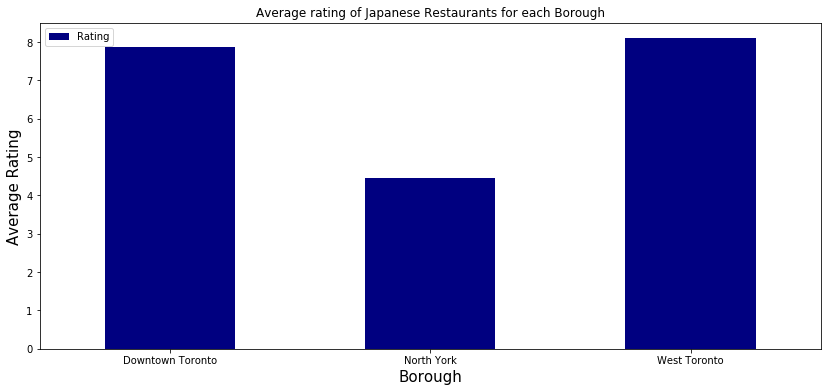

In [29]:
# Let's plot our results for ratings above
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_t.groupby('Borough').mean()['Rating'].plot(kind='bar', figsize=(14,6), color='navy')
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [30]:
# We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on a map
t_neighborhood_stats=t_neighborhood_stats[t_neighborhood_stats['Average Rating']>=7.0]
t_neighborhood_stats

,Neighbourhood,Average Rating
0,Central Bay Street,7.266667
1,Church and Wellesley,7.266667
2,"Commerce Court, Victoria Hotel",8.050000
5,"First Canadian Place, Underground city",7.825000
6,"Garden District, Ryerson",7.950000
8,"Harbourfront East, Union Station, Toronto Islands",8.900000
9,"Little Portugal, Trinity",8.100000
10,"Richmond, Adelaide, King",7.366667
11,St. James Town,8.450000
12,"St. James Town, Cabbagetown",8.700000


In [31]:
# We will join this Dataset to original Toronto data to get longitude and latitude
t_neighborhood_stats=pd.merge(t_neighborhood_stats,toronto_data, on='Neighbourhood')
t_neighborhood_stats=t_neighborhood_stats[['Borough','Neighbourhood','Latitude','Longitude','Average Rating']]
t_neighborhood_stats

,Borough,Neighbourhood,Latitude,Longitude,Average Rating
0,Downtown Toronto,Central Bay Street,43.657952,-79.387383,7.266667
1,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,7.266667
2,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,8.050000
3,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,7.825000
4,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,7.950000
5,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,8.900000
6,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,8.100000
7,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,7.366667
8,Downtown Toronto,St. James Town,43.651494,-79.375418,8.450000
9,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.700000


Now we will show above data applied to the map

### 4. Final Step: Visualization

In [35]:
# Create map and display it

t_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

# instantiate a feature group for the ratings in the dataframe

rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group

for lat, lng, in t_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [36]:
t_neighborhood_stats['Label']=t_neighborhood_stats['Neighbourhood']+', '+t_neighborhood_stats['Borough']+'('+t_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map

for lat, lng, label in t_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(t_map)
    
# add ratings to map

t_map.add_child(rating)

### Conclusion

In conclusion, in the city of Toronto there are only 33 Japanese Restaurants. For better results we have limited our research to higher rated Japanese Restaurants, specifically, starting from 7.0 on a 1.0 to 10.0 scale. Overall, majority of Restaurants located in Downtown Toronto, few are in West Toronto and lowest rated ones in North York. For ease of market entrance I would recommend West Toronto to potential investors due to less competitiveness in the area. For better results, improvements to this analysis can be applied.